In [146]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector

#from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("../data/brand_product_emotion.csv", encoding= 'unicode_escape')

In [30]:
sw = stopwords.words('english')

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    
    doc = regex_token.tokenize(doc)
    #doc = word_tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

# View Options

In [12]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#TO SEE EVERYTHING

In [21]:
pd.reset_option('all')
#RUN THIS WHEN DONE SEEING EVERYTHING PLS


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



F:\Anaconda\envs\learn-env\lib\site-packages\pandas\_config\config.py:622: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


### Cleaning up a bit

In [4]:
new_col_names = {'tweet_text': 'tweet', 
                 'emotion_in_tweet_is_directed_at':'device', 
                 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}
df = df.rename(columns=new_col_names)

In [5]:
df['emotion'] = df['emotion'].replace("Positive emotion","positive")
df['emotion'] = df['emotion'].replace("Negative emotion","negative")
df['emotion'] = df['emotion'].replace("No emotion toward brand or product","neutral")
df['emotion'] = df['emotion'].replace("I can't tell","unknown")

In [8]:
df_new = df[(df['emotion'] == 'positive') | (df['emotion'] == 'negative') | (df['emotion'] == 'neutral') ]

In [9]:
df_new['emotion'].value_counts()

neutral     5389
positive    2978
negative     570
Name: emotion, dtype: int64

In [23]:
#df[df['emotion'] == 'neutral']

In [24]:
emotion_map = {'neutral': 0, 'positive': 1, 'negative': 2}

In [25]:
df['target'] = df['emotion'].map(emotion_map)

In [26]:
df['target'].value_counts()
#should match with above 'emotion' value counts

0.0    5389
1.0    2978
2.0     570
Name: target, dtype: int64

### IMPORTANT TO NOTE:

From now on the target values will be:
- 0: neutral (no emotion toward brand)
- 1: positive emotion
- 2: negative emotion

In [27]:
df.drop('emotion', axis = 1, inplace = True)
df.drop('device', axis = 1, inplace = True)

In [28]:
df.dropna(inplace = True)

In [29]:
df['tweet'] = df['tweet'].astype('string')
df['target'] = df['target'].astype('float')

## Begin pipe for vectorizing -> kmeans
- To note, will just kmeans the whole df first.
    - Not expecting good results, just a prelim run of vect -> kmeans
- After this pipe, will make a new one for only 'neutral' df.
    - Will have to eyeball which group is pos/neg afterwards

In [128]:
X = df.tweet
y = df.target

In [129]:
X.head()

0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
Name: tweet, dtype: string

In [130]:
y.head()

0    2.0
1    1.0
2    1.0
3    2.0
4    1.0
Name: target, dtype: float64

In [131]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.20)

In [132]:
token_docs = [doc_preparer(doc, sw) for doc in X_train_temp]

In [133]:
# from the 80%, splitting 80-20 again for validation.
# X_valid/y_valid will be used for validation tests
X_train, X_valid, y_train, y_valid = train_test_split(token_docs,
                                                    y_train_temp,
                                                    random_state=42,
                                                    test_size=0.20)

In [134]:
fullpipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('kmeans', KMeans(n_clusters = 3, random_state = 42, n_init = 50, max_iter = 500, tol = 1e-5))
])

In [135]:
# Fit the pipeline on the training data
fullpipe.fit(X_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('kmeans',
                 KMeans(max_iter=500, n_clusters=3, n_init=50, random_state=42,
                        tol=1e-05))])

In [136]:
# Perform clustering on the test data
predictions = fullpipe.predict(X_valid)

In [137]:
# Convert labels to numpy array for indexing
y_valid = np.array(y_valid)

In [149]:
# Transform the test data into TF-IDF vectors
tfidf_vectors = fullpipe.named_steps['tfidf'].transform(X_valid)

In [155]:
tfidf_vectors = tfidf_vectors.toarray()

In [140]:
#print(predictions.shape)
#print(tfidf_vectors.shape)

(1430,)
(1430, 6203)


In [156]:
# Apply PCA to reduce dimensionality to 3
pca = PCA(n_components=3)
tfidf_vectors_pca = pca.fit_transform(tfidf_vectors)

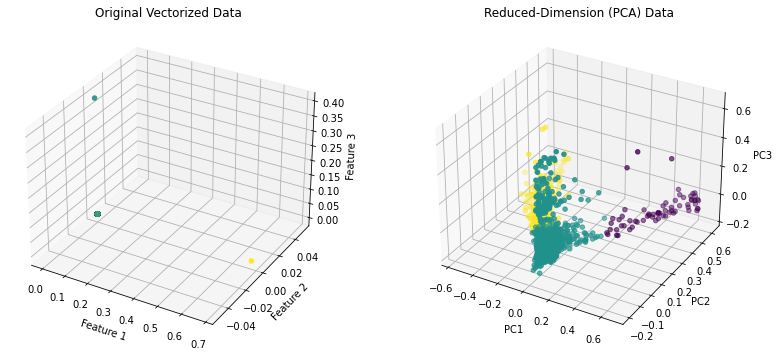

In [164]:
# Plot the vectorized data with predicted clusters in 3D
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(tfidf_vectors[:, 0], tfidf_vectors[:, 1], tfidf_vectors[:, 2], c=predictions)
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Feature 3")
ax1.set_title("Original Vectorized Data")

# Plot the reduced-dimension data with predicted clusters in 3D
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(tfidf_vectors_pca[:, 0], tfidf_vectors_pca[:, 1], tfidf_vectors_pca[:, 2], c=predictions)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")
ax2.set_title("Reduced-Dimension (PCA) Data")
plt.tight_layout()
plt.show()

Overview of what was done:
- vectorized data -> run into kmeans cluster
    - this was to split up in a new way. see if it makes sense
    - Will check original y_train vs new clusters

In [85]:
X_train

['google map useful get good sxsw',
 'mention google circle widely publicize next facebook completely forgotten end next week sxsw',
 'great idea behind circle rt mention amp mention google launch secret new social network call circle link sxsw',
 'rt mention rt mention google launch major new social network call circle link sxsw nptech',
 'rt mention head austin sxsw mention austin guide iphone free limited time link lp',
 'awesome iphone case mention sxsw',
 'cool google basically foing version apple event show ton new product feature sxsw',
 'think see maybe non apple notebook entire time mostly macbook pro macbooks many many ipad sxsw',
 'prefer news iphone ipad droid mention apps mention mention amp mention mobile apps sxsw',
 'diller google tv quot first product good consumer product basically quot sxsw diller',
 'rt mention free stuff alert download mention new austin guide free week link sxsw',
 'sxsw hootsuite chilltab tablet stand rock canadian social medium ipad best mention

In [93]:
type(y_train)

pandas.core.series.Series

In [94]:
y_train

7480    1.0
3332    0.0
1812    1.0
6543    1.0
5973    0.0
       ... 
7832    0.0
7565    0.0
7033    1.0
3420    1.0
5524    1.0
Name: target, Length: 5718, dtype: float64

In [86]:
fullpipe.named_steps['kmeans'].inertia_

5315.113855369214

In [110]:
y_train_newclust = y_train

In [111]:
y_train_newclust.value_counts

<bound method IndexOpsMixin.value_counts of 7480    1.0
3332    0.0
1812    1.0
6543    1.0
5973    0.0
       ... 
7832    0.0
7565    0.0
7033    1.0
3420    1.0
5524    1.0
Name: target, Length: 5718, dtype: float64>

In [98]:
labels_array = fullpipe.named_steps['kmeans'].labels_

In [114]:
y_train_newclust.index

Int64Index([7480, 3332, 1812, 6543, 5973, 7371, 3028, 1521, 2864,  588,
            ...
             528, 9000, 4306,  406, 5042, 7832, 7565, 7033, 3420, 5524],
           dtype='int64', length=5718)

In [115]:
counter = 0
#counter is for labels_array iteration
for ind in y_train_newclust.index:
    y_train_newclust[ind] = labels_array[counter]
    counter += 1

In [168]:
y_train_newclust.unique()

array([1., 0., 2.])

In [169]:
np.unique(y_train, return_counts=True)

(array([0., 1., 2.]), array([3450, 1913,  355], dtype=int64))

In [170]:
np.unique(y_train_newclust, return_counts=True)

(array([0., 1., 2.]), array([ 279, 4560,  879], dtype=int64))

I spent too damn long to come to the conclusion its not going to yield a good result if we try using kmeans onto the whole thing.
- Will try on just the 'neutral' data instead